In [1]:
# en caso de que lo hagais fuera de colab tendreis que instalar este modulo
#!pip install cmake 'gym[atari]' scipy

# Ejemplo de diseño: Taxi auto-conducido
Vamos a diseñar una simulación de un taxi autoconducido. El objetivo principal es demostrar, en un entorno simplificado, cómo se pueden utilizar las técnicas de RL para desarrollar un enfoque eficiente y seguro para abordar este problema.

El trabajo del Smartcab es recoger al pasajero en un lugar y dejarlo en otro. Estas son algunas de las cosas de las que nos gustaría que nuestro Smartcab se encargara:

* Dejar al pasajero en el lugar correcto.
* Ahorrar tiempo al pasajero tardando lo mínimo posible en dejarle.
* Cuidar la seguridad del pasajero y las normas de tráfico

Hay diferentes aspectos que hay que considerar aquí mientras se modela una solución RL para este problema: recompensas, estados y acciones.

## 1. Recompensas
Dado que el agente (el conductor imaginario) está motivado por la recompensa y va a aprender a controlar el taxi mediante experiencias de prueba en el entorno, tenemos que decidir las recompensas y/o penalizaciones y su magnitud en consecuencia. He aquí algunos puntos a tener en cuenta:

* El agente debe recibir una alta recompensa positiva por una entrega exitosa porque este comportamiento es muy deseado
* El agente debe ser penalizado si intenta dejar a un pasajero en lugares equivocados
* El agente debería recibir una ligera recompensa negativa por no llegar al destino después de cada paso de tiempo. "Ligeramente" negativo porque preferimos que nuestro agente llegue tarde en lugar de hacer movimientos erróneos tratando de llegar al destino lo más rápido posible

## 2. Espacio de estados
En el aprendizaje por refuerzo, el agente se encuentra con un estado, y entonces toma una acción de acuerdo con el estado en el que se encuentra.

El espacio de estados es el conjunto de todas las situaciones posibles en las que puede encontrarse nuestro taxi. El estado debe contener información útil que el agente necesita para realizar la acción correcta.

Digamos que tenemos un espacio de entrenamiento para nuestro Smartcab en el que le estamos enseñando a transportar personas en un aparcamiento a cuatro lugares diferentes (R, G, Y, B):

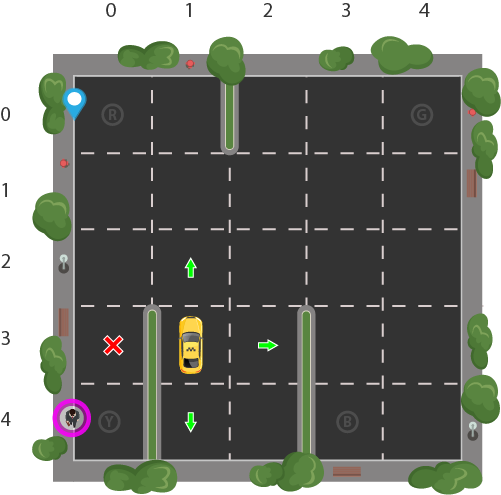

Supongamos que el Smartcab es el único vehículo en este aparcamiento. Podemos dividir el aparcamiento en una cuadrícula de 5x5, lo que nos da 25 posibles ubicaciones de taxis. Estas 25 localizaciones son una parte de nuestro espacio de estado. Fíjate que el estado de ubicación actual de nuestro taxi es la coordenada (3, 1).

También notarás que hay cuatro (4) ubicaciones en las que podemos recoger y dejar a un pasajero: R, G, Y, B o [(0,0), (0,4), (4,0), (4,3)] en coordenadas (row, col). Nuestro pasajero ilustrado se encuentra en la ubicación Y y desea ir a la ubicación R.

Si también tenemos en cuenta el estado de un (1) pasajero adicional que se encuentra dentro del taxi, podemos tomar todas las combinaciones de ubicaciones de pasajeros y ubicaciones de destino para llegar a un número total de estados para nuestro entorno de taxi; hay cuatro (4) destinos y cinco (4 + 1) ubicaciones de pasajeros.

Por tanto, nuestro entorno de taxi tiene un total de 5×5×5×4=500 estados posibles.

3. Espacio de acción
El agente se encuentra con uno de los 500 estados y realiza una acción. La acción en nuestro caso puede ser moverse en una dirección o decidir recoger/dejar a un pasajero.

En otras palabras, tenemos seis acciones posibles:

* sur
* norte
* este
* oeste
* recogida
* dejar

Este es el espacio de acción: el conjunto de todas las acciones que nuestro agente puede realizar en un estado determinado.

En la ilustración anterior se observa que el taxi no puede realizar ciertas acciones en determinados estados debido a las paredes. En el código del entorno, simplemente proporcionaremos una penalización de -1 por cada pared golpeada y el taxi no se moverá a ninguna parte. Esto sólo acumulará penalizaciones haciendo que el taxi considere rodear la pared.

In [2]:
import gym

env = gym.make("Taxi-v3").env

env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



### Recordatorio de nuestro problema
Este es el enunciado de nuestro problema reestructurado:

"Hay 4 lugares (etiquetados con letras diferentes), y nuestro trabajo es recoger al pasajero en un lugar y dejarlo en otro. Recibimos +20 puntos por dejar al pasajero con éxito y perdemos 1 punto por cada paso de tiempo que tardemos. También hay una penalización de 10 puntos por acciones ilegales de recogida y entrega".

Profundicemos en el entorno.

In [3]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


El cuadrado relleno representa el taxi, que es amarillo sin pasajero y verde con pasajero.

El tubo ("|") representa un muro que el taxi no puede cruzar.

R, G, Y, B son las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.

Como se comprueba en las impresiones, tenemos un Espacio de Acción de tamaño 6 y un Espacio de Estado de tamaño 500. Como verás, nuestro algoritmo RL no necesitará más información que estas dos cosas. Todo lo que necesitamos es una forma de identificar un estado de forma única asignando un número único a cada estado posible, y RL aprende a elegir un número de acción de 0 a 5 donde

* 0 = sur
* 1 = norte
* 2 = este
* 3 = oeste
* 4 = recogida
* 5 = recogida

Recordemos que los 500 estados corresponden a una codificación de la ubicación del taxi, la ubicación del pasajero y la ubicación del destino.

El aprendizaje por refuerzo aprenderá un mapeo de los estados con la acción óptima a realizar en ese estado mediante la exploración, es decir, el agente explora el entorno y realiza acciones basadas en las recompensas definidas en el entorno.

La acción óptima para cada estado es la que tiene la mayor recompensa acumulada a largo plazo

In [4]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## La tabla de recompensas
Cuando se crea el entorno Taxi, también se crea una tabla de recompensas inicial, llamada `P`. Podemos pensar en ella como una matriz que tiene el número de estados como filas y el número de acciones como columnas, es decir, una matriz de estados × acciones.

Como cada estado está en esta matriz, podemos ver los valores de recompensa por defecto asignados al estado de nuestra ilustración:

In [5]:
env.P[328] #por ejemplo

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

Este diccionario tiene la estructura {acción: [(probabilidad, siguiente estado, recompensa, hecho(true/false))]}.

## Resolver el entorno sin Aprendizaje por Refuerzo
Veamos qué pasaría si intentamos resolver el problema por fuerza bruta sin RL.

Ya que tenemos nuestra tabla P para las recompensas por defecto en cada estado, podemos intentar que nuestro taxi navegue sólo usando eso.

Crearemos un bucle infinito que se ejecutará hasta que un pasajero llegue a un destino (un episodio), o en otras palabras, cuando la recompensa recibida sea 20. El método env.action_space.sample() selecciona automáticamente una acción al azar del conjunto de todas las acciones posibles.

Veamos qué ocurre:

In [6]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1685
Penalties incurred: 561


In [7]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1685
State: 0
Action: 5
Reward: 20


No es bueno. Nuestro agente tarda miles de pasos de tiempo y hace muchas entregas erróneas para llevar a un solo pasajero al destino correcto.

Esto es porque no estamos aprendiendo de la experiencia pasada. Podemos ejecutar esto una y otra vez, y nunca se optimizará. El agente no tiene memoria de qué acción fue la mejor para cada estado, que es exactamente lo que el aprendizaje por refuerzo hará por nosotros.

## Introducir el aprendizaje por refuerzo
Vamos a utilizar un algoritmo simple de RL llamado Q-learning que dará a nuestro agente algo de memoria.

### Tabla Q
La tabla Q es una matriz en la que tenemos una fila para cada estado (500) y una columna para cada acción (6). Primero se inicializa a 0, y luego se actualizan los valores después del entrenamiento. Obsérvese que la tabla Q tiene las mismas dimensiones que la tabla de recompensas, pero tiene un propósito completamente diferente.

#### Resumen del proceso de Q-Learning
Desglosándolo en pasos, obtenemos

Inicializar la tabla Q con todos los ceros.
Empezar a explorar las acciones: Para cada estado, seleccionar una cualquiera entre todas las acciones posibles para el estado actual (S).
Viajar al siguiente estado (S') como resultado de esa acción (a).
Para todas las acciones posibles del estado (S') selecciona la que tenga el valor Q más alto.
Actualizar los valores de la tabla Q utilizando la ecuación.
Establecer el siguiente estado como el estado actual.
Si se alcanza el estado objetivo, se termina y se repite el proceso.

## Implementación de Q-learning en python
### Entrenamiento del agente
Primero, inicializaremos la tabla Q con una matriz de 500×6 ceros:

In [8]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Ahora podemos crear el algoritmo de entrenamiento que actualizará esta tabla Q a medida que el agente explore el entorno a lo largo de miles de episodios.

En la primera parte del while not done, decidimos si escoger una acción aleatoria o explotar los valores Q ya calculados. Esto se hace simplemente utilizando el valor epsilon y comparándolo con la función random.uniform(0, 1), que devuelve un número arbitrario entre 0 y 1.

Ejecutamos la acción elegida en el entorno para obtener el siguiente estado y la recompensa de realizar la acción. Después, calculamos el valor Q máximo de las acciones correspondientes al siguiente_estado, y con eso, podemos actualizar fácilmente nuestro valor Q al nuevo valor_q:

In [9]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: user 49.9 s, sys: 5.33 s, total: 55.3 s
Wall time: 50.8 s


Ahora que la tabla Q se ha establecido sobre 100.000 episodios, veamos cuáles son los valores Q en el estado de nuestra ilustración:

In [10]:
q_table[328]

array([ -2.40701897,  -2.27325184,  -2.41089319,  -2.35895436,
       -10.81225085, -10.91126863])

## Evaluación del agente
Vamos a evaluar el rendimiento de nuestro agente. No necesitamos explorar más acciones, así que ahora la siguiente acción se selecciona siempre utilizando el mejor valor Q:

In [11]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.01
Average penalties per episode: 0.0
